In [1]:
import netCDF4 as nc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
#import zipfile
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors


In [10]:
import netCDF4 as nc
import numpy as np

def replace_empty_and_non_numeric(var):
    # Check if the value is empty, NaN, or not a number
    return np.where((var == '') | (np.isnan(var)) | (np.isinf(var)), 0, var)

# Open the NetCDF file
input_file = 'MESH_drainage_database.nc'
output_file = 'output.nc'

with nc.Dataset(input_file, 'r+') as ds:
    # Read the IAK variable
    iak_var = ds.variables['IAK'][:]
    
    # Replace empty or non-numeric values with 0
    iak_var_cleaned = replace_empty_and_non_numeric(iak_var)
    
    # Write the cleaned variable back to the NetCDF file
    ds.variables['IAK'][:] = iak_var_cleaned

# Save the modified data to a new NetCDF file
with nc.Dataset(output_file, 'w', format='NETCDF4') as new_ds:
    # Copy global attributes
    new_ds.setncatts(ds.__dict__)
    
    # Copy dimensions
    for name, dimension in ds.dimensions.items():
        new_ds.createDimension(name, (len(dimension) if not dimension.isunlimited() else None))
    
    # Copy variables
    for name, variable in ds.variables.items():
        new_var = new_ds.createVariable(name, variable.datatype, variable.dimensions)
        new_var.setncatts(variable.__dict__)
        new_ds.variables[name][:] = ds.variables[name][:]
    
    # Write the cleaned IAK variable
    new_ds.variables['IAK'][:] = iak_var_cleaned


/home/fuaday/virtual-envs/scienv/lib/python3.10/site-packages/numpy/ma/core.py:4078: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  check = compare(sdata, odata)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
import netCDF4 as nc
import numpy as np

def replace_empty_and_non_numeric(var):
    # Create a mask for non-numeric values
    mask = np.isnan(var) | np.isinf(var)
    
    # Handle case where variable might be an object array (e.g., strings)
    if var.dtype.kind in {'U', 'S', 'O'}:
        mask |= (var == '')
    
    # Replace masked values with 0
    var[mask] = 0
    return var

# Open the NetCDF file
input_file = 'MESH_drainage_database.nc'
output_file = 'output.nc'

# Open the input NetCDF file
with nc.Dataset(input_file, 'r') as ds:
    # Read the IAK variable
    iak_var = ds.variables['IAK'][:]
    
    # Replace empty or non-numeric values with 0
    iak_var_cleaned = replace_empty_and_non_numeric(iak_var)

    # Create the output NetCDF file
    with nc.Dataset(output_file, 'w', format='NETCDF4') as new_ds:
        # Copy global attributes
        new_ds.setncatts(ds.__dict__)
        
        # Copy dimensions
        for name, dimension in ds.dimensions.items():
            new_ds.createDimension(name, (len(dimension) if not dimension.isunlimited() else None))
        
        # Copy variables
        for name, variable in ds.variables.items():
            new_var = new_ds.createVariable(name, variable.datatype, variable.dimensions)
            new_var.setncatts(variable.__dict__)
            if name == 'IAK':
                # Write the cleaned IAK variable
                new_ds.variables[name][:] = iak_var_cleaned
            else:
                # Write other variables as they are
                new_ds.variables[name][:] = ds.variables[name][:]


In [2]:
# Paths
base_path = "/scratch/fuaday/ncrb-models/"
ddbnetcdf_path = os.path.join(base_path, "MESH-ncrb/MESH_drainage_database.nc")
climatedata_path = os.path.join(base_path, "easymore-outputs-merged/clm_Ysm_tmean.nc")
#zip_path = '/project/6008034/Climate_Forcing_Data/geospatial-data/HydroLakes/HydroLAKES_polys_v10_shp.zip'

shapefile_path = os.path.join(base_path, "geofabric-outputs/ncrb-geofabric")
ncrbshapefile_path = os.path.join(shapefile_path, "ncrb_subbasins.shp")
ncrb_rivshapefile_path = os.path.join(shapefile_path, "ncrb_rivers.shp")
lake_shapefile_path = os.path.join(shapefile_path, "HydrolakesV10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_ncrb.shp")



In [3]:
#ncrb_lakes = gpd.read_file(lake_shapefile_path).to_crs(epsg=4326)
ncrb_gdf = gpd.read_file(ncrbshapefile_path).to_crs(epsg=4326)
ncrb_gdf['COMID'] = ncrb_gdf['COMID'].astype(int)
#ncrb_riv_gdf = gpd.read_file(ncrb_rivshapefile_path).to_crs(epsg=4326)

# Load NetCDF data using a context manager to handle file closing
with nc.Dataset(ddbnetcdf_path) as dataset:
    # Extract variables directly into a DataFrame
    drainage_df = pd.DataFrame({
        'subbasin': dataset.variables['subbasin'][:].astype(int),
        'chnlslope': dataset.variables['ChnlSlope'][:],
        'chnllength': dataset.variables['ChnlLength'][:],
        'drainagearea': dataset.variables['DA'][:],
        'riverorder': dataset.variables['IAK'][:],
        'iwfflag': dataset.variables['IWF'][:]
    })

    # Extract land use classes and append as separate columns
    landuse_classes = dataset.variables['LandUse'][:]
    gru_class = dataset.variables['GRU'][:]
    for i, landuse in enumerate(landuse_classes):
        drainage_df[landuse] = gru_class[:, i]



In [5]:
drainage_df['subbasin'][:].astype(int)

0        71006628
1        71006557
2        71006663
3        71005616
4        71006734
           ...   
32271    71048671
32272    71048685
32273    71050686
32274    71050687
32275    71004266
Name: subbasin, Length: 32276, dtype: int64

In [6]:

climate_ds = nc.Dataset(climatedata_path)
precip_data = climate_ds.variables['RDRS_v2.1_A_PR0_SFC'][:]
climate_ds.close()

# Prepare climate DataFrame
climate_df = pd.DataFrame({
    'COMID': drainage_df['subbasin'][:].astype(int),
    'precann': np.ravel(precip_data * 3600).astype(np.float32)
})

# Merge DataFrames with GeoDataFrame
merged_gdf = ncrb_gdf.merge(drainage_df, left_on='COMID', right_on='subbasin', how='left')
final_merged_gdf = merged_gdf.merge(climate_df, on='COMID', how='left')

# Save the merged GeoDataFrame as a new shapefile
output_path = os.path.join(shapefile_path, "ncrb_shapefile_drainagedatabase.shp")
final_merged_gdf.to_file(output_path)

/tmp/ipykernel_19513/4031995371.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_merged_gdf.to_file(output_path)


In [ ]:

# climate_ds = nc.Dataset(climatedata_path)
# precip_data = climate_ds.variables['RDRS_v2.1_A_PR0_SFC'][:]
# climate_ds.close()

# # Prepare climate DataFrame
# climate_df = pd.DataFrame({
#     'COMID': climate_ds.variables['COMID'][:].astype(int),
#     'precann': np.ravel(precip_data * 3600).astype(np.float32)
# })

# # Merge DataFrames with GeoDataFrame
# merged_gdf = ncrb_gdf.merge(drainage_df, left_on='COMID', right_on='subbasin', how='left')
# final_merged_gdf = merged_gdf.merge(climate_df, on='COMID', how='left')

# # Save the merged GeoDataFrame as a new shapefile
# output_path = os.path.join(shapefile_path, "ncrb_shapefile_drainagedatabase.shp")
# final_merged_gdf.to_file(output_path)

In [ ]:
# # Merge DataFrame with GeoDataFrame based on 'subbasin'
# merged_gdf = gdf.merge(drainage_df, left_on='COMID', right_on='subbasin', how='left')
# cdataset = nc.Dataset(climatedata_path)
# fufu1 = cdataset.variables['COMID'][:]
# fufu2 = cdataset.variables['RDRS_v2.1_A_PR0_SFC'][:]
# cdataset.close()

# if fufu2.ndim > 1:
#     fufu2 = fufu2.ravel()

# # Create a DataFrame using data from the NetCDF file
# dfc = pd.DataFrame({
#     'CCOMID': np.array(fufu1, dtype=np.int32),  # Convert COMID to integer type
#     'precann': np.array(fufu2*3600, dtype=np.float32)  # Ensure RDRS_v2.1_A_PR0_SFC remains float32
# })

# merged_gdf2 = merged_gdf.merge(dfc, left_on='COMID', right_on='CCOMID', how='left')

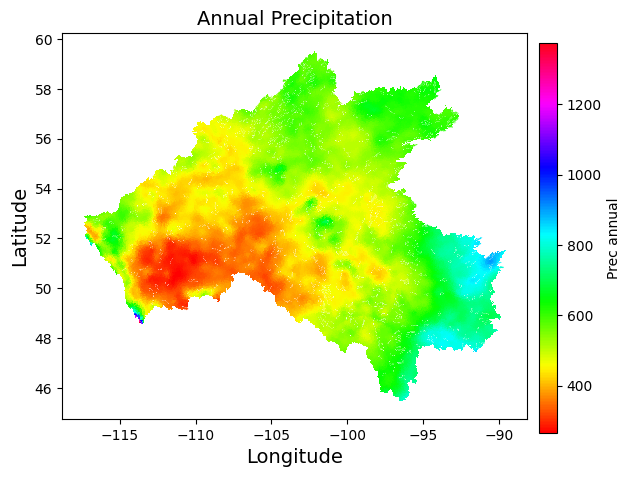

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# Plot Drainage area
viridis_r = plt.cm.get_cmap('hsv')#.reversed()
prec_mapping = final_merged_gdf.plot(column='precann', ax=ax, legend=False, vmin=final_merged_gdf['precann'].min(), vmax=final_merged_gdf['precann'].max(), cmap=viridis_r)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(prec_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
colorbar.set_label('Prec annual')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Annual Precipitation', fontsize=14)
# Save the figure
plt.savefig('AnnualPrecipitation.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()

In [ ]:
# Assume merged_gdf is already prepared and loaded as per your previous code
# Identify the last 16 columns and ignore the last one
gru_columns = merged_gdf.columns[-16:-1]  # Excludes the very last column

# Pre-calculate the percentage values
percentages = [(merged_gdf[col].sum() / len(merged_gdf) * 100) for col in gru_columns]
rounded_percentages = [round(p, 3) for p in percentages]

# Create a modified jet colormap that sets zero values to white
cmap = plt.cm.gnuplot2_r
cmap.set_under('white', alpha=0)
#cmap = plt.cm.jet
#cmap.set_under('white', alpha=0)

# Set up the figure and axes for a 3x5 grid (15 plots)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 9), sharex=True, sharey=True)

# Create an Image for colormap scaling
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=0.02, vmax=1))
sm._A = []  # Fake up the array of the scalar mappable. Urgh...

# Loop through and plot each column
for i, (col, rounded_percentage) in enumerate(zip(gru_columns, rounded_percentages)):
    ax = axes.flatten()[i]
    merged_gdf.plot(column=col, ax=ax, cmap=cmap, vmin=0.01, vmax=1)
    ax.set_title(col, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the pre-calculated percentage with a percentage sign in the top left corner of the subplot
    ax.text(0.05, 0.95, f"{rounded_percentage}%", transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.5))

# Hide any unused subplots
for i in range(len(gru_columns), axes.flatten().shape[0]):
    axes.flatten()[i].set_visible(False)

# Adjust layout
fig.tight_layout(pad=1.0)
fig.subplots_adjust(right=0.85, hspace=0.1, wspace=0.1)

# Place colorbar
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
fig.colorbar(sm, cax=cbar_ax)

# Save the figure if needed
plt.savefig('landuse_gru_plots.png')

# Show the plot
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot Drainage area
viridis_r = plt.cm.get_cmap('gnuplot2').reversed()
slope_mapping = merged_gdf.plot(column='drainagearea', ax=ax, legend=False, vmin=merged_gdf['drainagearea'].min(), vmax=merged_gdf['drainagearea'].max(), cmap=viridis_r)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(slope_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
colorbar.set_label('Slope Value')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Channel Slope and Lake Distribution', fontsize=14)
# Save the figure
#plt.savefig('Channel_Slope_and_Lakes.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()

In [ ]:
# Modify 'chnlslope' Values
#gdf['chnlslope'] = gdf['chnlslope'].apply(lambda x: 0 if x > 0.025 else x)
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot channel slope
viridis_r = plt.cm.get_cmap('gnuplot2').reversed()
slope_mapping = merged_gdf.plot(column='chnlslope', ax=ax, legend=False, vmin=merged_gdf['chnlslope'].min(), vmax=merged_gdf['chnlslope'].max(), cmap=viridis_r)
# Plot lakes
lake_mapping = ncrb_lakes.plot(ax=ax, color='#0066FF', alpha=1)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(slope_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
colorbar.set_label('Slope Value')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
ax.set_title('Channel Slope and Lake Distribution', fontsize=14)
# Save the figure
plt.savefig('Channel_Slope_and_Lakes.png', dpi=300)  # Adjust dpi for higher resolution
plt.show()

In [ ]:
!pip install contextily

In [ ]:
import contextily as ctx
# Load the subbasins, rivers, and lakes shapefiles
ncrb_subbasins_path = '/scratch/fuaday/J_Core_modeling/Nelson_project/Input_data_NCRB/Input_data_NCRB/NCRB_shapefiles/NCRB_Subbasins.shp'
ncrb_rivers_path = '/scratch/fuaday/J_Core_modeling/Nelson_project/Input_data_NCRB/Input_data_NCRB/NCRB_shapefiles/NCRB_River_75.shp'
ncrb_lakes_path = '/scratch/fuaday/ncrb-models/geofabric-outputs/ncrb-geofabric/HydrolakesV10/HydroLAKES_polys_v10_shp/HydroLAKES_polys_ncrb.shp'
ncrb_subbasins = gpd.read_file(ncrb_subbasins_path)
ncrb_rivers = gpd.read_file(ncrb_rivers_path)
ncrb_lakes = gpd.read_file(ncrb_lakes_path)
# Ensure all data is in the same CRS, here using EPSG:3857
ncrb_subbasins = ncrb_subbasins.to_crs(epsg=3857)
ncrb_rivers = ncrb_rivers.to_crs(epsg=3857)
ncrb_lakes = ncrb_lakes.to_crs(epsg=3857)
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
# Plot subbasins colored by 'MAJ_BAS'
ncrb_subbasins.plot(ax=ax, column='MAJ_BAS', legend=True, cmap='viridis', alpha=0.9)
# Plot rivers in a lighter blue with increased transparency
ncrb_rivers.plot(ax=ax, color='#00B0F0', linewidth=1, alpha=0.9)
# Plot lakes in a lighter '#0066FF' with increased transparency
ncrb_lakes.plot(ax=ax, color='#00B0F0', alpha=0.9)
# Add a basemap
ctx.add_basemap(ax, crs=ncrb_subbasins.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
# Optional: Adjust the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.5))
leg.set_title('Major Basin', prop={'size': 12})
# Adding labels and titles
ax.set_title('NCRB Subbasins, Rivers, and Lakes', fontsize=16)
ax.axis('off')  # Turn off the axis for a cleaner look
# Save the figure
plt.savefig('NCRB_Subbasins_Rivers_Lakes.png', dpi=300)  # Adjust dpi as needed for quality
plt.show()